# NLP Analysis of Swiss and US political pary programms

### Environment set-up

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# params
data_path = "data"

### Step 1. Get political programs as text

I identified top 6 Swiss parties according to the Wiki https://en.wikipedia.org/wiki/List_of_political_parties_in_Switzerland.

For each party I found the political program PDF and extracted contents as text (not in context of this Jupyter).

### Step 2. Preprocessing, Chunking and Translation of the data

I will first replace the names of the parties or other words that reveal the identity of the party by alternative words.

Than I will chunk the programms.

In [ ]:
from langchain_text_splitters import CharacterTextSplitter
from functools import reduce
import pandas as pd

# remove references to the party identity
replace_list = {
    "FDP": "Die Partei",
    "Die Mitte": "Die Partei",
    "die Mitte": "die Partei",
    "FREIEN DEMOKRATEN": "Leute",
    "Freien Demokraten": "Leute",
    "GLP": "Die Partei",
    "Grünliberale Partei": "Die Partei",
    "Grünliberale": "Leute",
    "Grünliberalen": "Leute",
    "GRÜNEN": "Leute",
    "GRÜNE": "Leute",
    "Green": "our",
    "Sozialdemokratischen Partei": "Partei",
    "Sozialdemokratische Partei": "Partei",
    "Sozialdemokraten": "Leute",
    "Sozialdemokrat": "Person",
    "sozialdemokratischen": "unsere",
    "sozialdemokratische": "unsere",
    "Sozialisten": "Leute",
    "Sozialiste": "Leute",
    "Sozialist": "Person",
    "SVP": "Partei",
}

# init splitter
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)

# init df
df = pd.DataFrame(columns=["party", "chunk"])

# split each of the party programms
for file in os.listdir(f"{data_path}/raw"):
    if file[-3:] == 'txt':

        # read it
        with open(f"{data_path}/raw/{file}") as f:
            text = f.read()

        # replace party identity strings
        text = reduce(lambda a, kv: a.replace(*kv), replace_list.items(), text)

        # split it
        texts = text_splitter.create_documents([text])

        # write chunks to df
        for chunk in texts:
            df = pd.concat([df,pd.Series({"party": file[:-4], "chunk": chunk.page_content}).to_frame().T], ignore_index=True)

# save data
df.to_csv(f"{data_path}/party_programms.csv", index=False)

### Step 3. Extract anonymized political ideas with LLM

1) I will extract the political ideas, values, concept or plans from chunks or political programs using LLM.

2) Than I will convert the list of programm chunks to a list of anonymized political ideas

In [ ]:
import pandas as pd
from openai import OpenAI

# read data
df = pd.read_csv(f"{data_path}/party_programms.csv")

# init openai client
client = OpenAI()

# config
data_path = "data"
prompt = """
Translate the chunk from german to english, extract and summarize up to 3 political values, concepts, plans or ideas from the following text chunk without revealing from which political party those are coming from. Output nothing, but those points in format of up to 3 sentances, starting each sentance with "POLITICAL IDEA:". Text chunk: {text_chunk} "
"""

def get_ideas(text_chunk):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
            {"role": "system", "content": "You are a political expert."},
            {
                "role": "user",
                "content": prompt.format(text_chunk=text_chunk)
            }
        ]
    )

    return completion.choices[0].message.content

# get completions
df["ideas"] = df["chunk"].apply(get_ideas)

# create new df with ideas
df_ideas = pd.DataFrame(columns=["party", "idea"])

# split ideas by "POLITICAL IDEA:"
for index, row in df.iterrows():
    ideas = [_.strip() for _ in row["ideas"].split("POLITICAL IDEA:")[1:]]
    for idea in ideas:
        df_ideas = pd.concat([df_ideas,pd.Series({"party": row["party"], "idea": idea}).to_frame().T], ignore_index=True)

# save data
df_ideas.to_csv(f"{data_path}/party_ideas.csv", index=False)

### Step 4. Embedding

I will than embed the ideas to build some reasonable statistics around them

In [ ]:
from openai import OpenAI

# read data
df = pd.read_csv(f"{data_path}/party_ideas.csv")

# init OpenAI client
client = OpenAI()

# for each chunk, get the embeddings
embeddings = []
for chunk in df["idea"]:
    response = client.embeddings.create(
        input=chunk,
        model="text-embedding-3-small"
    )
    embeddings.append(response.data[0].embedding)

# add embeddings to df
df["embedding"] = embeddings

# save data
df.to_csv(f"{data_path}/party_ideas.csv", index=False)

### Step 5. Build the classifier and create predictions on the test dataset

1) I will build a simple multilabel one-vs-rest logistic regression classifier
2) I will predict the test dataset

In [172]:
import pandas as pd
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# read data
df = pd.read_csv(f"{data_path}/party_ideas.csv")

# get counts for the least represented party
counts = df["party"].value_counts()
min_count = int(counts.min())

# sample the data
df = df.groupby("party").apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# split pandas 70/30
df_train = df.sample(frac=0.7)
df_test = df.drop(df_train.index)

# get embeddings and convert each to a numpy array
X_train = df_train["embedding"].apply(lambda x: np.array(eval(x)))
X_test = df_test["embedding"].apply(lambda x: np.array(eval(x)))

# one vs rest model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# fit model
clf.fit(list(X_train), df_train["party"])

# evaluate
print(f"Logistic regression score on train: {clf.score(list(X_train), df_train['party'])}")
print(f"Logistic regression score on test: {clf.score(list(X_test), df_test['party'])}")

# predict the test set
probas = clf.predict_proba(list(X_test))

# write probas to test df
for ind, class_name in enumerate(clf.classes_):
    df_test[f'proba_{class_name}'] = probas[:,ind]

# remove the embeddings
df_test = df_test.drop(columns=["embedding"])

# save data
df_test.to_csv(f"{data_path}/party_ideas_prediction.csv", index=False)

/var/folders/4d/ycr0kn4x3bx00_vwr13b2f140000gn/T/ipykernel_15773/3844494915.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("party").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


Logistic regression score on train: 0.7238095238095238
Logistic regression score on test: 0.6037037037037037


### Step 6. Explore party identity predictions on test dataset

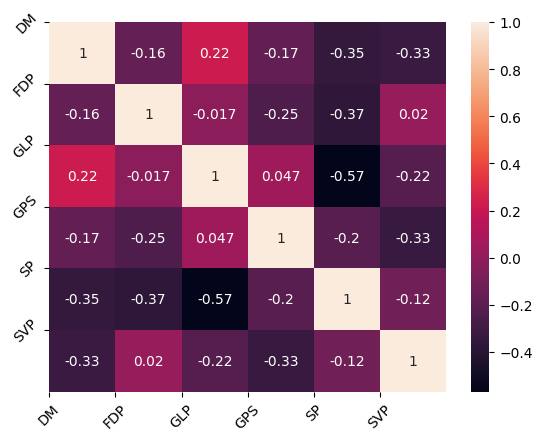

In [173]:
# correlation matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# read data
df = pd.read_csv(f"{data_path}/party_ideas_prediction.csv")

# get correlation matrix
corr = np.corrcoef(df[[f'proba_{_}' for _ in clf.classes_]].T)

# plot it
sns.heatmap(corr, annot=True)
plt.xticks(ticks=range(len(clf.classes_)), labels=clf.classes_, rotation=45)
plt.yticks(ticks=range(len(clf.classes_)), labels=clf.classes_, rotation=45)
plt.show()

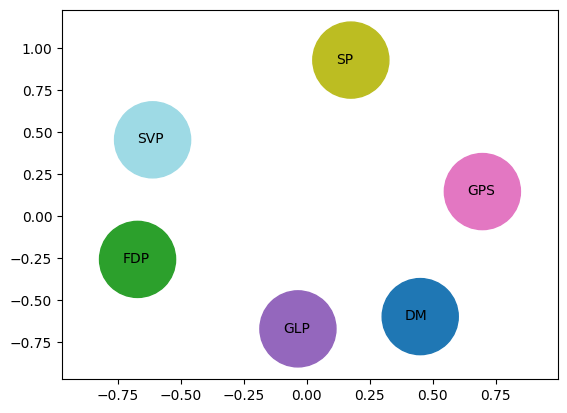

In [174]:
# convert the correlation matrix to distance matrix
dist = 1 - corr

# reduce distance matrix to 2D
from sklearn.manifold import MDS
mds = MDS(dissimilarity='precomputed')
X = mds.fit_transform(dist)

# plot it
plt.scatter(X[:,0], X[:,1], s=3000, c=range(len(clf.classes_)), cmap='tab20')
for i, txt in enumerate(clf.classes_):
    plt.annotate(txt, (X[i,0]-0.06, X[i,1]-0.02))
# add margin
plt.xlim([min(X[:,0])-0.3, max(X[:,0])+0.3])
plt.ylim([min(X[:,1])-0.3, max(X[:,1])+0.3])
plt.show()

### Explore ideas that clearly define party identity

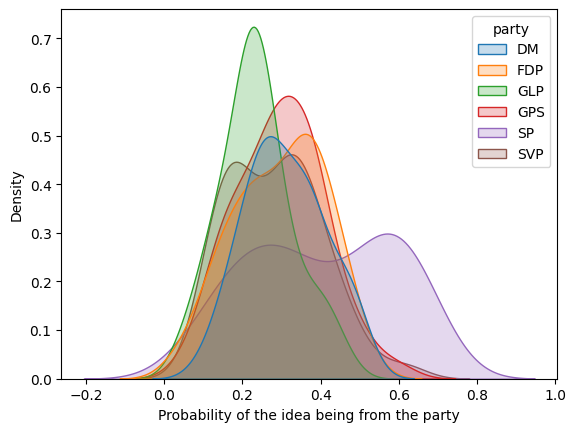

In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read data
df = pd.read_csv(f"{data_path}/party_ideas_prediction.csv")

# for each party, find the probability of idea being itw own
lookup_column = ['proba_' + _ for _ in df['party']]
df['party_proba'] = [df.loc[i, col] for i, col in enumerate(lookup_column)]

# save data
df.to_csv(f"{data_path}/party_ideas_prediction.csv", index=False)

# plot the kde
sns.kdeplot(data=df, x='party_proba', hue='party', fill=True)

# x axis
plt.xlabel("Probability of the idea being from the party")
plt.show()

In [179]:
# check the ideas of SP with party_proba over 0.6
df[(df['party'] == 'SP') & (df['party_proba'] > 0.6)]['idea']

182    Socialism cannot exist without freedom, emphas...
184    Democratic Socialism, on the other hand, is de...
185    The concept of democratic socialism is emphasi...
195    Socialism is seen as a powerful force in globa...
197    Socialist political goals include full employm...
199    The party rejects a capitalist economic order ...
218    The pursuit of a new society in freedom throug...
Name: idea, dtype: object

In [183]:
# for each party get top 10 ideas based on the party_proba and summarize them using LLM
from openai import OpenAI

# init openai client
client = OpenAI()

# config
prompt = """
Summarize following political ideas into maximum 3 bullet points with each bullet point being maximum 5 words long.
Ideas: {ideas} "
"""

def summarize_ideas(ideas):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
            {"role": "system", "content": "You are a political expert."},
            {
                "role": "user",
                "content": prompt.format(ideas=ideas)
            }
        ]
    )

    return completion.choices[0].message.content

# read data
df = pd.read_csv(f"{data_path}/party_ideas_prediction.csv")

# get top 10 ideas for each party
df_top_ideas = pd.DataFrame(columns=["party", "idea"])
for party in df["party"].unique():
    df_top_ideas = pd.concat([df_top_ideas, df[df["party"] == party].sort_values("party_proba", ascending=False).head(10)[["party", "idea"]]])

# for each party join all ideas with /n
df_top_ideas = df_top_ideas.groupby("party").apply(lambda x: "\n".join(x["idea"])).reset_index()

# rename this column to ideas
df_top_ideas.columns = ["party", "ideas"]

# summarize the ideas
df_top_ideas["summary"] = df_top_ideas["ideas"].apply(summarize_ideas)

# save data
df_top_ideas.to_csv(f"{data_path}/unique_party_ideas.csv", index=False)

/var/folders/4d/ycr0kn4x3bx00_vwr13b2f140000gn/T/ipykernel_15773/534455742.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_ideas = df_top_ideas.groupby("party").apply(lambda x: "\n".join(x["idea"])).reset_index()


In [186]:
# read data
df_top_ideas = pd.read_csv(f"{data_path}/unique_party_ideas.csv")

# print the summary
for index, row in df_top_ideas.iterrows():
    print(f"{row['party']}:\n{row['summary']}\n\n")

DM:
- Support older individuals independently: access support
- Promote age-friendly living arrangements: social engagement
- Improve public transportation: enhance efficiency


FDP:
Digitalize and simplify customs processes
Reframe EU-Switzerland institutional relations
Expand international trade agreements


GLP:
- Advocate for energy transition
- Utilize financial incentives for sustainability
- Promote sustainable agriculture and mobility


GPS:
- Recognizing right to healthy environment
- Implement feminist foreign policy
- Orient agenda around sustainability goals


SP:
- Socialism needs freedom for existence
- Socialist goals: full employment, prosperity
- Democratic socialism emphasizes diverse perspectives


SVP:
- Traditional family values, no state intervention
- Switzerland population limit, controlled immigration
- Expel illegal residents, limit immigrant benefits




## Explore shared ideas

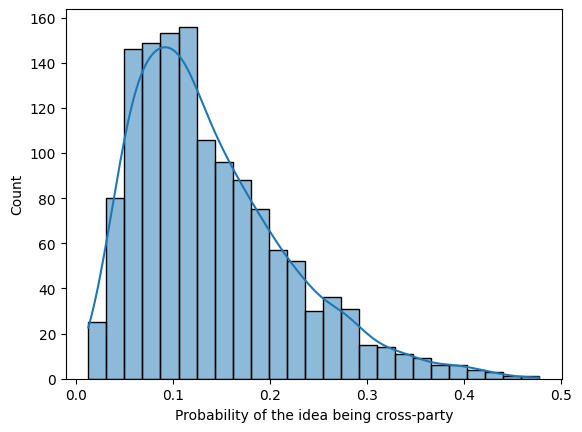

In [191]:
# read data
df = pd.read_csv(f"{data_path}/party_ideas_prediction.csv")

# collect probabilities of ideas
idea_probabilities = []
for party in df["party"].unique():
    df_party = df[df["party"] != party]
    idea_probabilities += list(df_party[f"proba_{party}"].values)

# plot the histogram
sns.histplot(idea_probabilities, kde=True)

# x axis
plt.xlabel("Probability of the idea being cross-party")

plt.show()

In [207]:
import pandas as pd

# read data
df = pd.read_csv(f"{data_path}/party_ideas_prediction.csv")

# init new df
cross_party_ideas = pd.DataFrame(columns=["party"])

# for each party, get the ideas with probability over the threshold
threshold = 0.39
for party in df["party"].unique():
    df_party = df[df["party"] != party]
    df_party = df_party[df_party[f"proba_{party}"] > threshold][["party", "idea",f"proba_{party}"]]
    df_party["seems_to_be"] = party
    # rename proba column
    df_party = df_party.rename(columns={f"proba_{party}": "proba"})
    cross_party_ideas = pd.concat([cross_party_ideas, df_party])

# save it
cross_party_ideas.to_csv(f"{data_path}/cross_party_ideas.csv", index=False)

cross_party_ideas

,party,idea,proba,seems_to_be
50,FDP,Supporting targeted and individualized approac...,0.430961,DM
75,FDP,Advocating for more affordable housing and hom...,0.440894,DM
114,GLP,Supporting the rapid adoption of modern device...,0.398779,DM
10,DM,Streamlining government processes to be effici...,0.403839,FDP
19,DM,Streamlining legal procedures and exploring wa...,0.433254,FDP
157,GPS,Simplification and streamlining of procedures ...,0.407079,FDP
27,DM,Prioritizing family responsibility for childca...,0.410978,GLP
227,SVP,Advocacy for the protection of individual and ...,0.423060,SP
247,SVP,"Defending independence, self-determination, an...",0.393361,SP
39,FDP,Emphasis on safeguarding political independenc...,0.397197,SVP
